In [1]:
import os
import sys

REPO_DIRECTORY = f"{os.getcwd()}/../.."
sys.path.append(REPO_DIRECTORY)

In [2]:
import coconut
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import transformers
import tqdm

In [3]:
MODEL_ARCHITECTURE = "openai-community/gpt2"
COCONUT_CHECKPOINT = "/home/ubuntu/nethome/reasoning/git/coconut/YOUR_PATH_TO_SAVE_THE_MODEL/gsm-coconut/checkpoint_4"
# DATA_DIRECTORY = "./data/chains-of-thoughts/openai-community/gpt2/checkpoint_15.pkl"
DATA_DIRECTORY = "/home/ubuntu/nethome/reasoning/git/coconut/data/cot_pos_neg.csv"
# COCONUT_CHECKPOINT = "/home/ubuntu/nethome/reasoning/git/coconut/YOUR_PATH_TO_SAVE_THE_MODEL/gsm-cot/checkpoint_15"
GPU_ID = 0
MAX_NEW_TOKENS = 100
N_SEQUENCES = 15

In [4]:
model = transformers.AutoModelForCausalLM.from_pretrained(MODEL_ARCHITECTURE)
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_ARCHITECTURE)
tokenizer.pad_token = tokenizer.eos_token

coconut_tokens = ["<|latent|>", "<|start-latent|>", "<|end-latent|>"]
tokenizer.add_tokens(coconut_tokens)
token_ids = tokenizer.convert_tokens_to_ids(coconut_tokens)

model.resize_token_embeddings(len(tokenizer))
embeddings = model.get_input_embeddings()
target_id = tokenizer.convert_tokens_to_ids("<<")

for token_id in token_ids:
    target_embedding = embeddings.weight.data[token_id]
    embeddings.weight.data[token_id] = target_embedding

model = coconut.Coconut(model, *token_ids, tokenizer.eos_token_id)

# checkpoint = f"{REPO_DIRECTORY}/{COCONUT_CHECKPOINT}"
checkpoint = COCONUT_CHECKPOINT
weights = torch.load(checkpoint, torch.device(GPU_ID), weights_only=False)
model.load_state_dict(weights, strict=False)
_ = model.to(GPU_ID)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [5]:
def coconut_next_token_distribution(
    model: coconut.Coconut,
    input_ids: torch.Tensor,
    **kwargs,
) -> torch.Tensor:
    gen_fwd_cnt = 0

    assert input_ids.shape[0] == 1, "only support batch_size == 1 now"

    outputs = model.forward(
        input_ids,
        torch.ones_like(input_ids, device=input_ids.device),
        input_ids.clone(),
        torch.arange(
            0, input_ids.shape[1], dtype=torch.long, device=input_ids.device
        ).reshape(1, -1),
        **kwargs,
    )

    return torch.nn.functional.softmax(outputs.logits[:, -1], dim=1)

In [10]:
LATENT_RANGE = (1, 5)
QUESTION_RANGE = None # None means all questions

df = pd.read_csv(f"{DATA_DIRECTORY}")
results = pd.DataFrame()

q_idxs = [*set(df["q_idx"])] if QUESTION_RANGE is None else range(*QUESTION_RANGE)

df = df[~df["correct_anwser"].isna()]
df = df[~df["pred_anwser"].isna()]

for n_latents in range(*LATENT_RANGE):
    for q_idx in tqdm.tqdm(q_idxs, desc="Question range"):
        _df = df[df.q_idx == q_idx]


        for _, entry in [*_df.iterrows()]:
            try:
                steps = [f"<<{s}>>\n" for s in entry["pred_steps"].split(",")]
            except:
                print(entry["pred_steps"])
            
            # Error handling stuff
            if len(steps) <= n_latents:
                continue


            question = entry["question"]
            question += "<|start-latent|>" + "<|latent|>" * n_latents + "<|end-latent|>"

            target = question + "".join(steps[n_latents:])
            target += "###" + str(int(entry["pred_anwser"]))

            q_sequence = tokenizer(question, return_tensors="pt").to(GPU_ID)["input_ids"].squeeze()
            t_sequence = tokenizer(target, return_tensors="pt").to(GPU_ID)["input_ids"].squeeze()


            token_ids = range(len(q_sequence), len(t_sequence))

            log_product = 0
            for token_id in token_ids:
                model_input = torch.stack([t_sequence[:token_id]])
                distribution = coconut_next_token_distribution(model, model_input)
                distribution = distribution.squeeze().cpu().detach().numpy()

                target_token = int(t_sequence[token_id])
                prob = np.log2(distribution[target_token])

                log_product += prob



            # geometric_mean = product ** (1 / len(token_ids))
            geometric_mean = 2 ** (log_product / len(token_ids))

            results = pd.concat([
                results,
                pd.DataFrame([{
                    "q_idx": q_idx, 
                    "log_product": log_product,
                    "geometric_mean": geometric_mean,
                    "correct": entry["correct_anwser"],
                    "solution_length": len(token_ids),
                    "n_latents": n_latents,
                }]),
            ])

Question range:  16%|█▌        | 211/1319 [04:43<24:46,  1.34s/it]  


AttributeError: 'float' object has no attribute 'split'

<Axes: xlabel='n_latents,correct'>

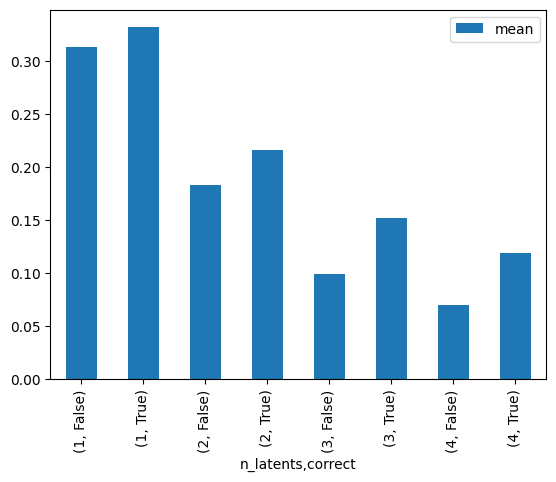

In [7]:
pd.options.display.max_rows = 1000
results.groupby(['n_latents', 'correct',])['geometric_mean'].agg(['mean', 'std']).plot.bar(y='mean')

In [8]:
num = results.groupby(['q_idx','correct','n_latents']).size().unstack('correct')
filtern = num[(num[False]>=2)&(num[True]>=2)]
filtern

results_filter = results.groupby(['q_idx','n_latents', 'correct'])['geometric_mean'].mean().reset_index()
results_filter = results_filter.merge(filtern.reset_index()[['q_idx','n_latents']])
#results_filter = results_filter.pivot(columns='correct', index=['q_idx','n_latents'], values='geometric_mean')

<Axes: xlabel='n_latents,correct'>

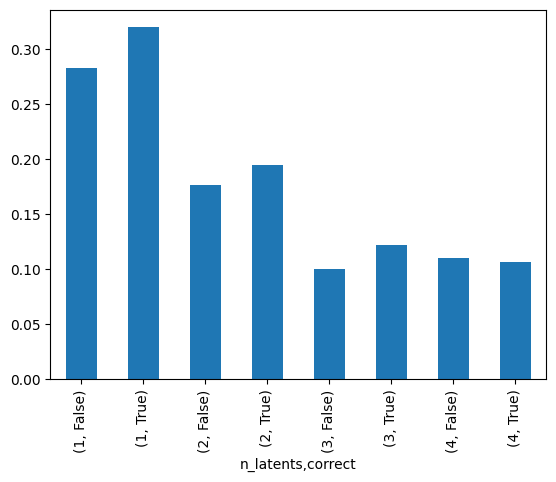

In [9]:
results_filter.groupby(['n_latents','correct'])['geometric_mean'].mean().plot.bar()